## Importing the relevant libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=86af4e42357fb52dab61e9bba1062b251d3bf120d48e57f416490ab5a4e6f173
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 13.7 MB/s eta 0:00:00


In [4]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 84.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, wget
warnings.filterwarnings('ignore')
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")
import tensorflow as tf
import keras_tuner as kt
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.metrics import classification_report, accuracy_score, precision_score, f1_score, recall_score
from tqdm.notebook import tqdm
tqdm.pandas()
from helper_prabowo_ml import clean_html, remove_links, non_ascii, lower, email_address, removeStopWords, punct, remove_, remove_special_characters, remove_digits

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
plt.rcParams['figure.figsize'] = (12,8) # Setting the default figure size

## Loading the dataset

In [7]:
df_nlp = pd.read_csv("/content/drive/MyDrive/Capstone/ML/dataset/Dataset - sentiment (3).csv")
df_nlp.head()

,text,label,4,4.1
0,"I like fridays generally, but class is extende...",neutral,92,92
1,Mc John sim posit 3 yr passed no softees stran...,neutral,93,93
2,I tried that pincode... and it says it is expi...,neutral,77,77
3,I`ve always been a ppl person just hid behind ...,neutral,95,95
4,"Is it me (my machine)? or... Vids freeze up, h...",neutral,91,91


## Data Exploration, Exploratory Data Analysis (EDA) and Feature Engineering

In [8]:
df_nlp.shape

(10297, 4)

In [9]:
df_nlp.label.value_counts()

happy      2522
neutral    2374
fear       2252
joy        1616
sadness    1533
Name: label, dtype: int64

In [10]:
df_nlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10297 entries, 0 to 10296
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10297 non-null  object
 1   label   10297 non-null  object
 2   4       10297 non-null  object
 3   4.1     10297 non-null  object
dtypes: object(4)
memory usage: 321.9+ KB


In [11]:
df_nlp.isnull().sum()

text     0
label    0
4        0
4.1      0
dtype: int64

In [12]:
df_nlp.duplicated().sum()

1

In [13]:
## Checking for any empty strings within the text column
df_nlp.text.str.isspace().sum()

0

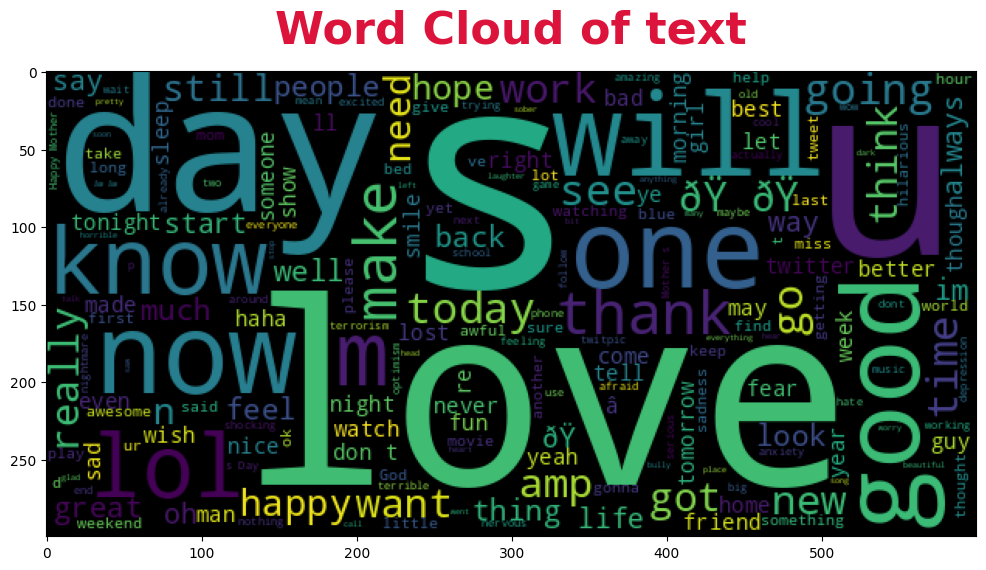

In [14]:
wc = WordCloud(width=600,height=300,random_state=101).generate(' '.join(df_nlp.text))
plt.imshow(wc)
plt.title('Word Cloud of text',fontsize=32,fontweight='bold',color='crimson',pad=20);

In [15]:
df_nlp['text_len'] = df_nlp.text.apply(len)
df_nlp.head()

,text,label,4,4.1,text_len
0,"I like fridays generally, but class is extende...",neutral,92,92,92
1,Mc John sim posit 3 yr passed no softees stran...,neutral,93,93,93
2,I tried that pincode... and it says it is expi...,neutral,77,77,77
3,I`ve always been a ppl person just hid behind ...,neutral,95,95,95
4,"Is it me (my machine)? or... Vids freeze up, h...",neutral,91,91,91


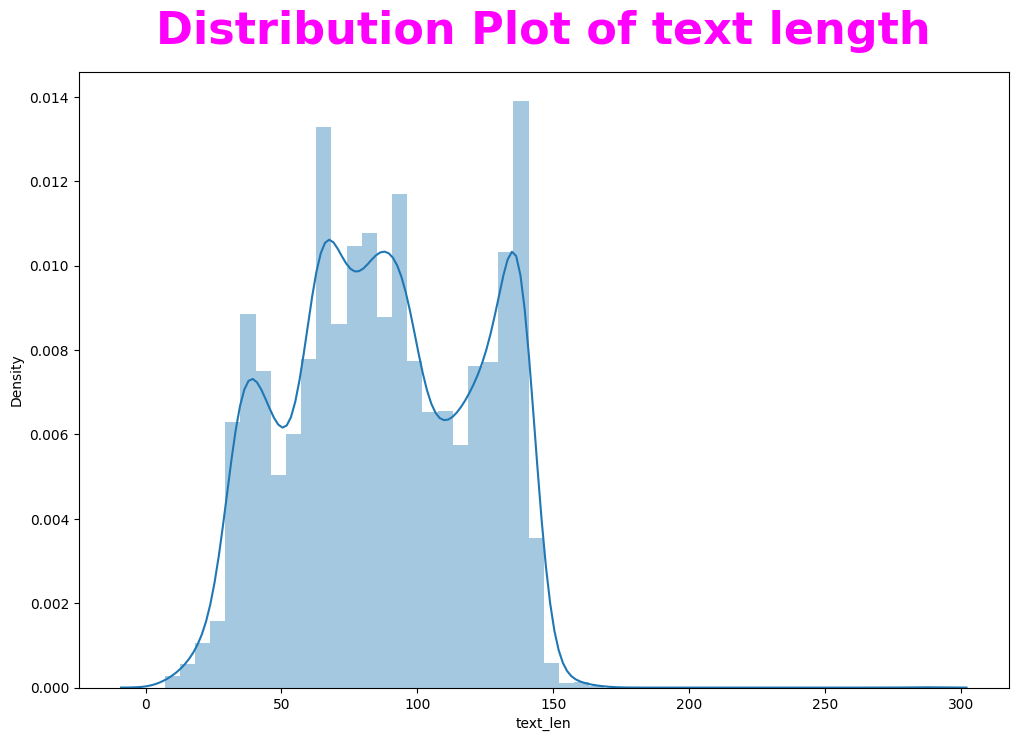

In [16]:
sns.distplot(df_nlp.text_len)
plt.title('Distribution Plot of text length',fontsize=32,color='magenta',fontweight='bold',pad=20);

In [17]:
df_nlp.describe()

,text_len
count,10297.000000
mean,87.609109
std,33.865811
min,7.000000
25%,62.000000
50%,86.000000
75%,118.000000
max,286.000000


In [18]:
max_text_len = 90 # Setting the max text length to its average value

## Encoding the target labels

In [19]:
labels_dict = {}

for idx, label in enumerate(df_nlp.label.unique()):
    labels_dict[label] = idx

labels_dict

{'neutral': 0, 'fear': 1, 'sadness': 2, 'joy': 3, 'happy': 4}

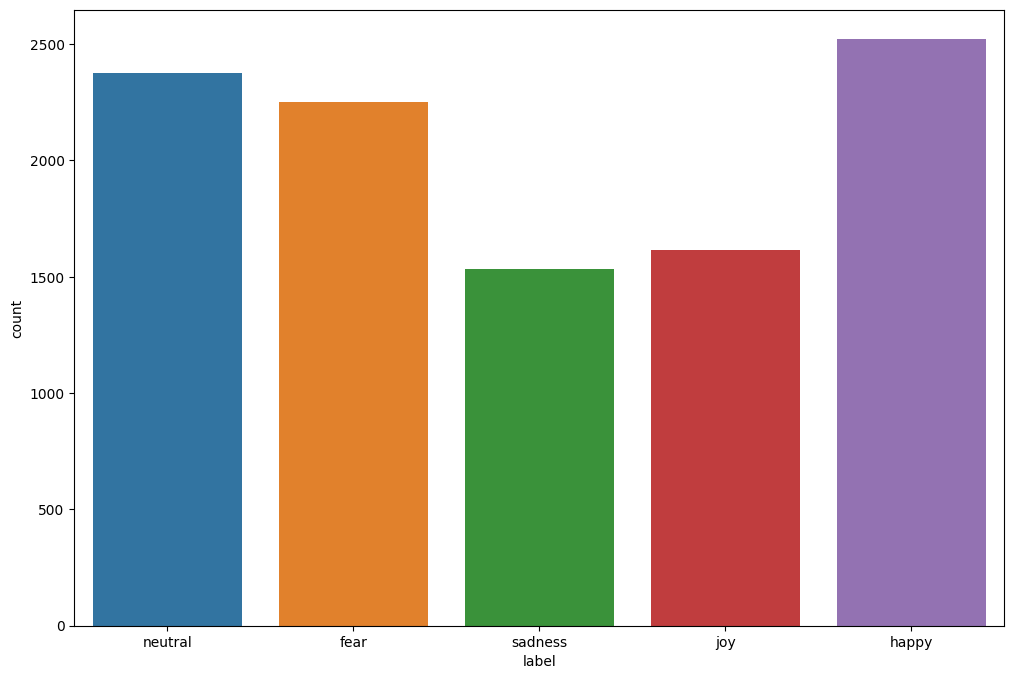

In [20]:
sns.countplot(df_nlp,x='label');

There are 4 emotions in total, fear, sadness, joy and anger. As is evident from the above graph, the class "fear" has the highest instances, which is followed by the emotions "anger", "joy" and "sadness" with "sadness" having the least instances.

In [21]:
df_nlp.label = df_nlp.label.apply(lambda x: labels_dict[x])

## Preprocessing the text data

In [22]:
def text_preprocess(data,col):
    data[col] = data[col].progress_apply(func=clean_html) # Eliminates HTML tags and other HTML syntax
    data[col] = data[col].progress_apply(func=punct) # Removes punctuation characters
    data[col] = data[col].progress_apply(func=remove_) # Removes underspace characters
    data[col] = data[col].progress_apply(func=remove_digits) # Removes digits
    data[col] = data[col].progress_apply(func=remove_links) # Eliminates links and URLs
    data[col] = data[col].progress_apply(func=remove_special_characters) # Removes special characters
    data[col] = data[col].progress_apply(func=removeStopWords) # Removes stopwords
    data[col] = data[col].progress_apply(func=lower) # Converts text to lowercase
    data[col] = data[col].progress_apply(func=non_ascii) # Removes non-ASCII characters
    data[col] = data[col].progress_apply(func=email_address) # Removes email addresses
    return data

In [23]:
preprocessed_df = text_preprocess(df_nlp,'text')
preprocessed_df.head()

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

  0%|          | 0/10297 [00:00<?, ?it/s]

,text,label,4,4.1,text_len
0,fridays generally class extended today starvin...,0,92,92,92
1,mc john sim posit yr passed softees stranded w...,0,93,93,93
2,tried pincode says expired put,0,77,77,77
3,always ppl person hid behind bad self confiden...,0,95,95,95
4,is machine vids freeze halt whole blip stream ...,0,91,91,91


## Downloading the pretrained tokenizer and BERT transformer model from the Hugging Face platform

In [24]:
tokenizer = AutoTokenizer.from_pretrained('LawalAfeez/emotion_detection')
bert_model = TFAutoModelForSequenceClassification.from_pretrained('LawalAfeez/emotion_detection')

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at LawalAfeez/emotion_detection.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


## Splitting the preprecessed dataset into train and test sets

In [25]:
train_df_nlp, test_df_nlp = train_test_split(preprocessed_df,test_size=0.3,random_state=101,shuffle=True,stratify=preprocessed_df.label)

## Performing tokenization of text data

In [26]:
X_train_nlp = tokenizer(text=train_df_nlp.text.tolist(),
                   add_special_tokens=True,
                   padding="max_length",
                   truncation=False,
                   max_length=max_text_len,
                   return_tensors='tf',
                   return_token_type_ids=False,
                   return_attention_mask=True,
                   verbose=1)

X_test_nlp = tokenizer(text=test_df_nlp.text.tolist(),
                  add_special_tokens=True,
                  padding="max_length",
                  truncation=False,
                  max_length=max_text_len,
                  return_tensors='tf',
                  return_token_type_ids=False,
                  return_attention_mask=True,
                  verbose=1)

## Defining the model architecture

In [27]:
input_ids = Input(shape=(max_text_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_text_len,),dtype=tf.int32,name='attention_mask')

In [28]:
word_embeddings = bert_model(input_ids, attention_mask=attention_mask)[0]

output = Flatten()(word_embeddings)
output = Dense(units=2048, activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=1024, activation='relu')(output)
output = Dropout(0.25)(output)
output = Dense(units=512, activation='relu')(output)
output = Dense(units=5, activation='softmax')(output)

model_nlp = Model(inputs=[input_ids, attention_mask], outputs=output)
model_nlp.layers

In [29]:
# Making the pretrained BERT transformer model layer trainable so that it can be fine-tuned according to our custom dataset
model_nlp.layers[2].trainable = True

## Visualizing the model architecture

In [30]:
model_nlp.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 90)]         0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 90)]         0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66958086   ['input_ids[0][0]',              
 assification (TFDistilBertForS  rOutput(loss=None,               'attention_mask[0][0]']         
 equenceClassification)         logits=(None, 6),                                                 
                                 hidden_states=None                                           

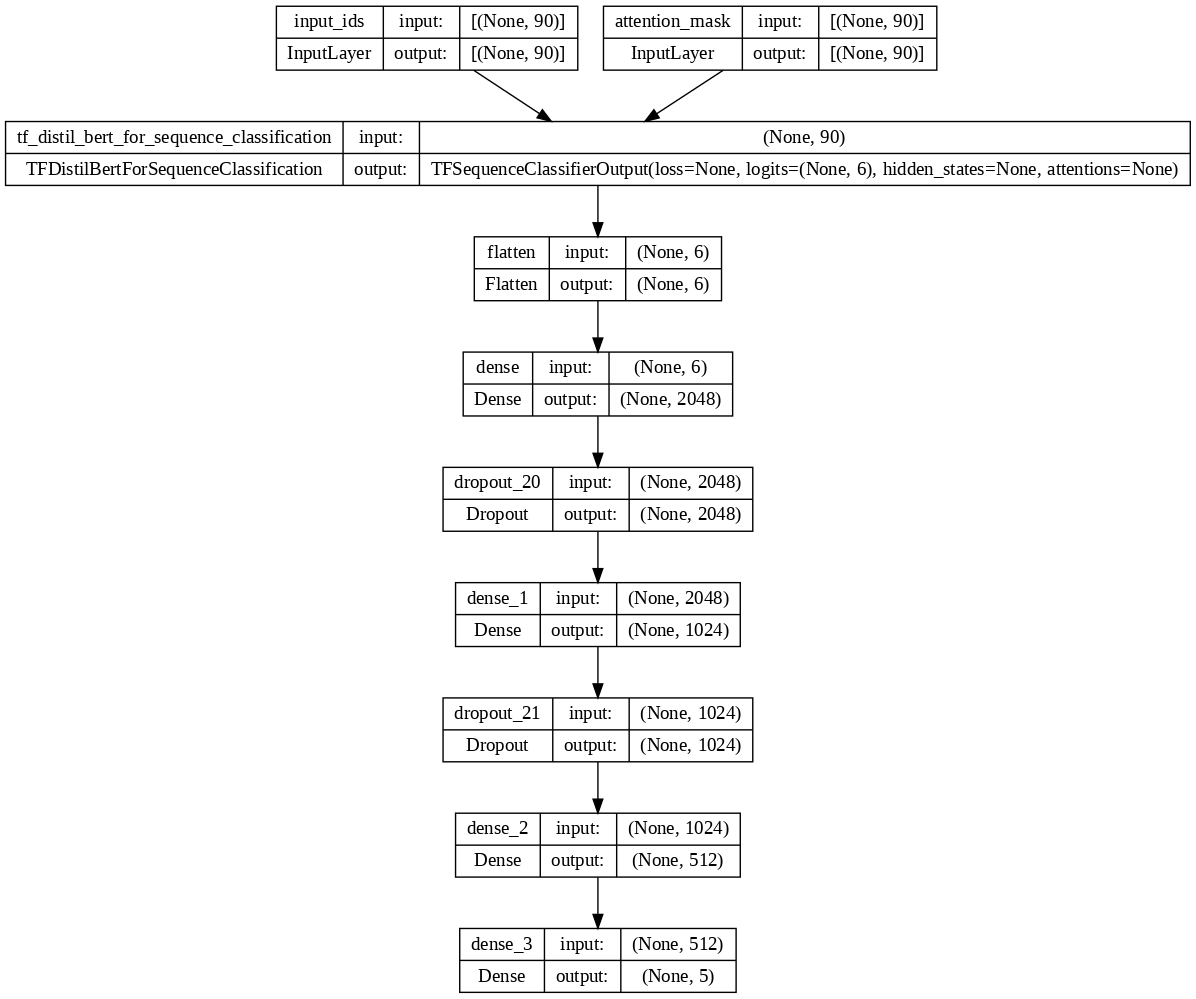

In [31]:
plot_model(model_nlp,to_file='fine-tuned_transformer_model.png',dpi=100,show_shapes=True)

## Compiling the model

In [32]:
adam_nlp = Adam(learning_rate=5e-5,
           epsilon=2e-8,
           weight_decay=1e-2,
           clipnorm=1.0)

model_nlp.compile(loss='categorical_crossentropy',optimizer=adam_nlp,metrics='categorical_accuracy')

## Training the fine-tuned BERT transformer model

In [33]:
es = EarlyStopping(monitor='val_categorical_accuracy',patience=1,mode='max',verbose=1,restore_best_weights=True,start_from_epoch=1)
mc = ModelCheckpoint('emotion_detector.h5',monitor='val_categorical_accuracy',verbose=1,save_best_only=True,mode='max')

r = model_nlp.fit(x={'input_ids': X_train_nlp['input_ids'], 'attention_mask': X_train_nlp['attention_mask']},
             y=to_categorical(train_df_nlp.label),
             epochs=3,
             batch_size=64,
             callbacks=[es,mc],
             validation_data=({'input_ids': X_test_nlp['input_ids'], 'attention_mask': X_test_nlp['attention_mask']},to_categorical(test_df_nlp.label))
             )

Epoch 1/3
113/113 [==============================] - ETA: 0s - loss: 1.0251 - categorical_accuracy: 0.6051
Epoch 1: val_categorical_accuracy improved from -inf to 0.75987, saving model to emotion_detector.h5
113/113 [==============================] - 117s 692ms/step - loss: 1.0251 - categorical_accuracy: 0.6051 - val_loss: 0.6728 - val_categorical_accuracy: 0.7599
Epoch 2/3
113/113 [==============================] - ETA: 0s - loss: 0.5789 - categorical_accuracy: 0.7995
Epoch 2: val_categorical_accuracy improved from 0.75987 to 0.78026, saving model to emotion_detector.h5
113/113 [==============================] - 73s 649ms/step - loss: 0.5789 - categorical_accuracy: 0.7995 - val_loss: 0.6159 - val_categorical_accuracy: 0.7803
Epoch 3/3
113/113 [==============================] - ETA: 0s - loss: 0.3898 - categorical_accuracy: 0.8697
Epoch 3: val_categorical_accuracy improved from 0.78026 to 0.79094, saving model to emotion_detector.h5
113/113 [==============================] - 72s 638ms/

In [34]:
model_nlp.save('emotion_detector_model.h5')
tokenizer.save_pretrained('tokenizer')

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/vocab.txt',
 'tokenizer/added_tokens.json',
 'tokenizer/tokenizer.json')

## Visualizing the model performance during training

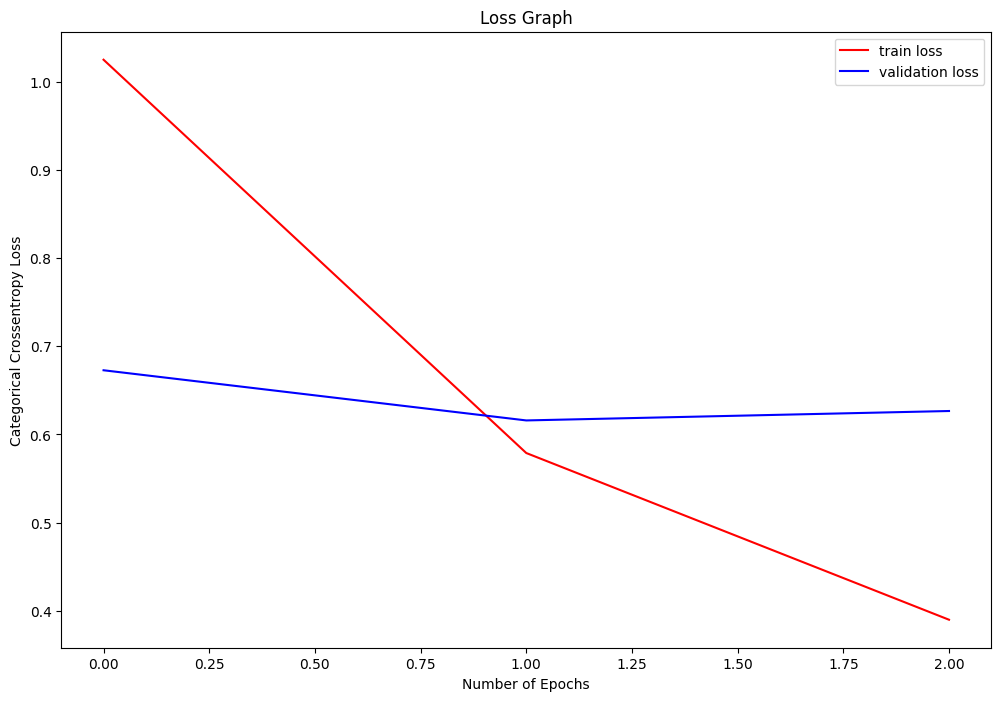

In [35]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

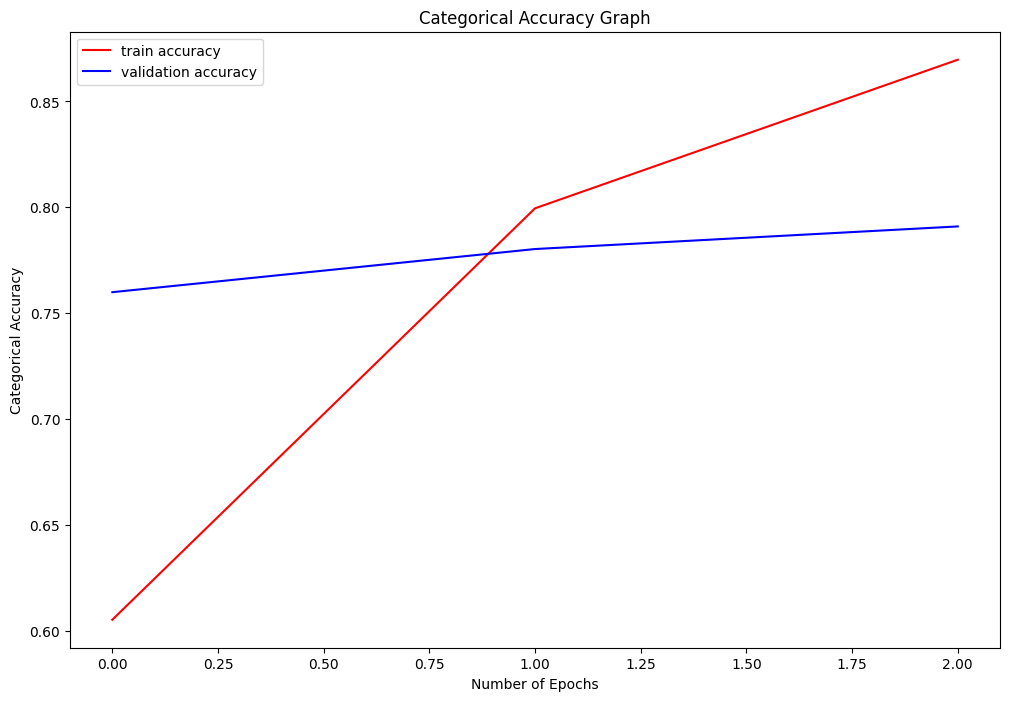

In [36]:
plt.plot(r.history['categorical_accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_categorical_accuracy'],'b',label='validation accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Categorical Accuracy')
plt.title('Categorical Accuracy Graph')
plt.legend();

## Tuning the hyperparameters of the fine-tuned BERT transformer model

In [ ]:
# def build_model(hp):
#     input_ids = Input(shape=(max_text_len,),dtype=tf.int32,name='input_ids')
#     attention_mask = Input(shape=(max_text_len,),dtype=tf.int32,name='attention_mask')
#     word_embeddings = bert_model(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
#     output = Flatten()(word_embeddings)

#     for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
#         output = Dense(units=hp.Int('units'+str(i),min_value=32,max_value=1024,step=32),
#                        activation=hp.Choice("activation",["relu","tanh","sigmoid"]))(output)
#         output = BatchNormalization()(output)
#         output = Dropout(hp.Choice('dropout'+str(i),values=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]))(output)

#     output = Dense(units=4,activation='softmax')(output)
#     model = Model(inputs=[input_ids,attention_mask],outputs=output)
#     model.layers[2].trainable = True
#     optimizer = hp.Choice('optimizer',values=['adam','rmsprop','sgd','adadelta','nadam'])
#     model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics='categorical_accuracy')
#     return model

In [ ]:
# tuner = kt.RandomSearch(build_model,
#                         objective=kt.Objective(name='val_categorical_accuracy',direction='max'),
#                         project_name='hyperparameter-tuning',
#                         directory='my_dir')

In [ ]:
# tuner.search({'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
#              to_categorical(train_df.label),
#              epochs=50,
#              batch_size=64,
#              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}, to_categorical(test_df.label)))

In [ ]:
# tuner.get_best_hyperparameters()[0].values # Displaying the most optimal hyperparameters

In [ ]:
# try:
#     final_model = tuner.get_best_models(num_models=1)[0] # Fetching the best performing model
#     print(final_model)
# except Exception as e:
#     print(e)

## Evaluating the performance of the fine-tuned DistilBERT transformer model on test data

### Baseline fine-tuned DistilBERT model evaluation

In [37]:
loss_nlp, acc_nlp = model_nlp.evaluate({'input_ids': X_test_nlp['input_ids'], 'attention_mask': X_test_nlp['attention_mask']},to_categorical(test_df_nlp.label))
print("Test Sparse Categorical Balanced Crossentropy Loss:",loss_nlp)
print("Test Balanced Categorical Accuracy:",acc_nlp)

97/97 [==============================] - 10s 102ms/step - loss: 0.6266 - categorical_accuracy: 0.7909
Test Sparse Categorical Balanced Crossentropy Loss: 0.626602292060852
Test Balanced Categorical Accuracy: 0.7909384965896606


In [38]:
test_predictions_nlp = model_nlp.predict({'input_ids': X_test_nlp['input_ids'], 'attention_mask': X_test_nlp['attention_mask']})
test_predictions_nlp = np.argmax(test_predictions_nlp,axis=1)
print("Dictionary of encoded labels:",labels_dict)
print("Classification Report:")
print(classification_report(test_df_nlp.label,test_predictions_nlp))

97/97 [==============================] - 12s 103ms/step
Dictionary of encoded labels: {'neutral': 0, 'fear': 1, 'sadness': 2, 'joy': 3, 'happy': 4}
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       712
           1       0.90      0.80      0.84       676
           2       0.84      0.84      0.84       460
           3       0.90      0.87      0.89       485
           4       0.76      0.72      0.74       757

    accuracy                           0.79      3090
   macro avg       0.81      0.80      0.80      3090
weighted avg       0.80      0.79      0.79      3090



In [39]:
print("Accuracy Score:",accuracy_score(test_df_nlp.label,test_predictions_nlp))
print("Micro-Averaged Precision Score:",precision_score(test_df_nlp.label,test_predictions_nlp,average='micro'))
print("Macro-Averaged Precision Score:",precision_score(test_df_nlp.label,test_predictions_nlp,average='macro'))
print("Weighted Precision Score:",precision_score(test_df_nlp.label,test_predictions_nlp,average='weighted'))
print("Micro-Averaged Recall Score:",recall_score(test_df_nlp.label,test_predictions_nlp,average='micro'))
print("Macro-Averaged Recall Score:",recall_score(test_df_nlp.label,test_predictions_nlp,average='macro'))
print("Weighted Recall Score:",recall_score(test_df_nlp.label,test_predictions_nlp,average='weighted'))
print("Micro-Averaged F1 Score:",f1_score(test_df_nlp.label,test_predictions_nlp,average='micro'))
print("Macro-Averaged F1 Score:",f1_score(test_df_nlp.label,test_predictions_nlp,average='macro'))
print("Weighted F1 Score:",f1_score(test_df_nlp.label,test_predictions_nlp,average='weighted'))

Accuracy Score: 0.7909385113268609
Micro-Averaged Precision Score: 0.7909385113268609
Macro-Averaged Precision Score: 0.8102188319368077
Weighted Precision Score: 0.799422053914282
Micro-Averaged Recall Score: 0.7909385113268609
Macro-Averaged Recall Score: 0.8009805791093221
Weighted Recall Score: 0.7909385113268609
Micro-Averaged F1 Score: 0.7909385113268609
Macro-Averaged F1 Score: 0.8038201602262542
Weighted F1 Score: 0.7931702262035009


### Model evaluation after tuning the hyperparameters of fine-tuned DistilBERT model

In [ ]:
# loss, acc = final_model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.label))
# print("Test Sparse Categorical Balanced Crossentropy Loss:",loss)
# print("Test Balanced Categorical Accuracy:",acc)

In [ ]:
# test_predictions = final_model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
# test_predictions = np.argmax(test_predictions,axis=1)
# print("Dictionary of encoded labels:",labels_dict)
# print("Classification Report:")
# print(classification_report(test_df.label,test_predictions))

In [ ]:
# print("Accuracy Score:",accuracy_score(test_df.label,test_predictions))
# print("Micro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='micro'))
# print("Macro-Averaged Precision Score:",precision_score(test_df.label,test_predictions,average='macro'))
# print("Weighted Precision Score:",precision_score(test_df.label,test_predictions,average='weighted'))
# print("Micro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='micro'))
# print("Macro-Averaged Recall Score:",recall_score(test_df.label,test_predictions,average='macro'))
# print("Weighted Recall Score:",recall_score(test_df.label,test_predictions,average='weighted'))
# print("Micro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='micro'))
# print("Macro-Averaged F1 Score:",f1_score(test_df.label,test_predictions,average='macro'))
# print("Weighted F1 Score:",f1_score(test_df.label,test_predictions,average='weighted'))

In [43]:
from tensorflow import keras
from tensorflow.keras.utils import register_keras_serializable
from transformers import TFDistilBertForSequenceClassification
from tensorflow.keras.models import load_model
from transformers import AutoTokenizer

register_keras_serializable(TFDistilBertForSequenceClassification)

# bikin fungsi buat ngeload semua lapisan2 dari bert yang bukan lapisan standar dari tf
def custom_objects():
    return {"TFDistilBertForSequenceClassification": TFDistilBertForSequenceClassification}

with keras.utils.custom_object_scope(custom_objects()):
    model_nlp = keras.models.load_model("emotion_detector_model.h5")
tokenizer = AutoTokenizer.from_pretrained("tokenizer")


test_predictions_nlp = model_nlp.predict({'input_ids': X_test_nlp['input_ids'], 'attention_mask': X_test_nlp['attention_mask']})
test_predictions_nlp = np.argmax(test_predictions_nlp,axis=1)
print("Dictionary of encoded labels:",labels_dict)
print("Classification Report:")
print(classification_report(test_df_nlp.label,test_predictions_nlp))

97/97 [==============================] - 12s 98ms/step
Dictionary of encoded labels: {'neutral': 0, 'fear': 1, 'sadness': 2, 'joy': 3, 'happy': 4}
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.77      0.71       712
           1       0.90      0.80      0.84       676
           2       0.84      0.84      0.84       460
           3       0.90      0.87      0.89       485
           4       0.76      0.72      0.74       757

    accuracy                           0.79      3090
   macro avg       0.81      0.80      0.80      3090
weighted avg       0.80      0.79      0.79      3090

